In [1]:
# imports
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re
from itertools import product
from functools import partial


# constants
MIN_T = 3
MAX_T = 28

min_t = pd.Timedelta(days=MIN_T)
max_t = pd.Timedelta(days=MAX_T)

In [4]:
x_samples=[int(e) for e in """30661
30038
31068
30049
30371
30891
30104
30434
30537
30542
30266
31022
30512
30927
31140
31581
30939
30788
31141
31224
31307
31110
31194
31268
31777
30572
30096
30165
30094
30230
30355
30316
30688
30394
30543
30665
30582
30853
30758
30848
30725
30875
31227
31424
31708
31456
32015""".splitlines()]

In [11]:
intsct_31 = """30049
31141
30230
31068
31140
30665
30434
30355
30371
30537
30542
31708
30266
31581
31307
30104
31224
31110
31194
31227
31777
30788
30891
31268
30939
30725
30038
30543
30661
30572
31022""".splitlines()
intsct_31 = [int(e) for e in intsct_31]
intsct_31

[30049,
 31141,
 30230,
 31068,
 31140,
 30665,
 30434,
 30355,
 30371,
 30537,
 30542,
 31708,
 30266,
 31581,
 31307,
 30104,
 31224,
 31110,
 31194,
 31227,
 31777,
 30788,
 30891,
 31268,
 30939,
 30725,
 30038,
 30543,
 30661,
 30572,
 31022]

In [5]:
# previous label sets
mdro_pos_large = pd.read_csv('./mdro_large_metadata.csv')
mdro_pos_large.sort_values(['StudyID', 'SampleDate'], inplace=True)
mdro_pos_large.index = mdro_pos_large['Stool ID']
mdro_pos_small = pd.read_csv('./mdro_pos.csv')
mdro_pos_small.index = mdro_pos_small['Stool ID']
mdro_pos_small = mdro_pos_small.loc[x_samples, :]
mdro_pos_small.sort_values(['StudyID', 'SampleDate'], inplace=True)

# previous StudyID
mdro_pos_large_sid = mdro_pos_large.StudyID.unique()
mdro_pos_small_sid = mdro_pos_small.StudyID.unique()

# get time vars
mdro_pos_small.SampleDate = mdro_pos_small.SampleDate.apply(lambda x: pd.Timestamp(x))
mdro_pos_small.future_sample_date = mdro_pos_small.future_sample_date.apply(lambda x: pd.Timestamp(x))
mdro_pos_large.SampleDate = mdro_pos_large.SampleDate.apply(lambda x: pd.Timestamp(x))
mdro_pos_large.future_sample_date = mdro_pos_large.future_sample_date.apply(lambda x: pd.Timestamp(x))

In [6]:
# raw data
md = pd.read_excel('PLT_all_stool_isolates_seq_old.xlsx')
md.sort_values(['StudyID', 'SampleDate'], inplace=True)

# select only the patients relevant for each dataset
md_large = md.loc[md.StudyID.isin(mdro_pos_large_sid),:]
md_large.reset_index(drop=True, inplace=True)
md_small = md.loc[md.StudyID.isin(mdro_pos_small_sid),:]
md_small.reset_index(drop=True, inplace=True)

# assert patient list is the same, in the same order
assert(all(md_large.StudyID.unique() == mdro_pos_large_sid))
assert(all(md_small.StudyID.unique() == mdro_pos_small_sid))

# get absolute course dates
abx  = pd.read_excel('PLT_Abx_Courses_Tal2.xlsx')
abx 
tx = md[['TxDate', 'StudyID']].dropna().drop_duplicates()
tx.index = tx.StudyID
tx = tx.TxDate
abx['course_start_date'] = abx.apply(lambda r: tx[r.StudyID] + pd.Timedelta(days=r.course_start_daysposttx), axis=1)
abx['course_end_date'] = abx.apply(lambda r: tx[r.StudyID] + pd.Timedelta(days=r.course_end_daysposttx), axis=1)
abx['course_duration'] = (abx.course_end_daysposttx - abx.course_start_daysposttx) + 1

#get future seq
mdro_pos_small['future_sequenced'] = mdro_pos_small.apply(lambda r: md.loc[md['Stool ID'] == r['future_stool'], 'sequenced'].values[0], axis=1)
mdro_pos_large['future_sequenced'] = mdro_pos_large.apply(lambda r: md.loc[md['Stool ID'] == r['future_stool'], 'sequenced'].values[0], axis=1)

In [7]:
def any_MDRO(s):
    rgx=r'3\d{4}'
    esbl, kpc, vre = s[['ESBLisolate', 'KPCisolate', 'VRE +/-']]
    esbl = str(esbl)
    kpc = str(kpc)
    vre = str(vre)
    if ('+' in esbl or '+' in kpc or '+' in vre):
        return True
    elif re.search(rgx, esbl) or re.search(rgx, kpc) or re.search(rgx, vre):
        return True
    else:
        return False
    
def long_form_mdro_type(s, future=False):
    rgx=r'3\d{4}'
    p = s['persistence']
    if future:
        ns = md.loc[md['Stool ID'] == int(s.future_stool), :].iloc[0,:]
    else:
        ns = s
    mdro = ns[['ESBLisolate', 'KPCisolate', 'VRE +/-']]
    df = pd.DataFrame(columns=['StoolID', 'mdro_type', 'persistence'])
    tkns = ['ESBL', 'KPC', 'VRE']
    for i, bug in enumerate(mdro):
        bug = str(bug)
        if '+' in bug or re.search(rgx, bug) or 'BLUE?'in bug:
            df.loc[len(df), :] = [s['Stool ID'], tkns[i], p]
    return df


def switched_mdro(s):
    rgx=r'3\d{4}'
    mdro = lambda x: '+' in x or (True if re.search(rgx, x) else False) or 'BLUE?'in x
    fs = md.loc[md['Stool ID'] == int(s.future_stool), :].iloc[0,:]
    s_mdros = np.array([mdro(str(e)) for e in s[['ESBLisolate', 'KPCisolate', 'VRE +/-']]])
    fs_mdros = np.array([mdro(str(e)) for e in fs[['ESBLisolate', 'KPCisolate', 'VRE +/-']]])
    mdros = np.vstack([s_mdros, fs_mdros])
    return not (mdros.all(axis=0).any())
    
    


In [10]:
# MDRO POS SMALL

def course_days_to_date(abx_df, date):
    if abx_df.empty:
        return np.nan
    days = abx_df.loc[abx_df.course_end_date < date, 'course_duration'].sum()
    days = pd.Timedelta(days=days)
    if any((abx_df.course_start_date <= date) & (date <= abx_df.course_end_date)):
        days += (date - abx_df.loc[(abx_df.course_start_date <= date) & (date <= abx_df.course_end_date), :].course_start_date).sum() + pd.Timedelta(days=1)
    return days.days

def days_since_last_exposure(abx_df, date):
    if abx_df.empty:
        return np.nan
    if any((abx_df.course_start_date <= date) & (date <= abx_df.course_end_date)):
        # sample taken during exposure
        return 0
    if any(abx_df.course_end_date < date):
        return (date - abx_df.loc[abx_df.course_end_date < date,'course_end_date']).min().days
    
def days_exposure_btwn(abx_df, sample, future):
    if abx_df.empty:
        return np.nan
    ovlp_s = abx_df.course_start_date.apply(lambda x: max(x, sample))
    ovlp_e = abx_df.course_end_date.apply(lambda x: min(x, future))
    ovlp = (ovlp_e - ovlp_s).apply(lambda x: 0 if x.days < 0 else x.days + 1)
    return ovlp.sum()
    
   

future_sequenced  persistence
True              True           24
False             False          22
True              False           1
Name: count, dtype: int64

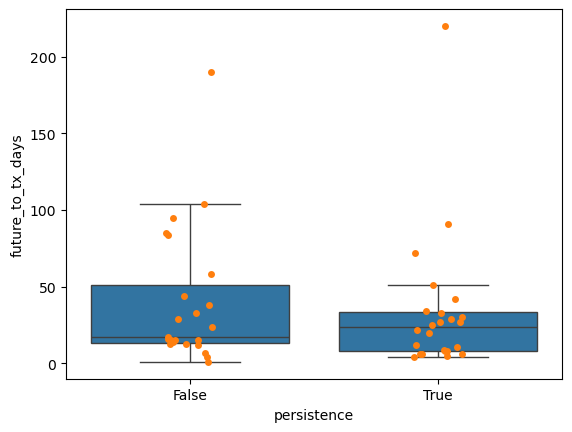

In [13]:
# ABX ANALYSIS FOR MDRO SMALL 
        
no_abx_info = list(set(mdro_pos_small.StudyID) - set(abx.groupby('StudyID').course_duration.sum().index))
mdro_pos_small['course_days_total'] = abx.groupby('StudyID').course_duration.sum().reindex(mdro_pos_small.StudyID).values
mdro_pos_small['course_days_to_sample'] = mdro_pos_small.apply(lambda r: course_days_to_date(abx.loc[abx.StudyID == r.StudyID,:], r.SampleDate), axis=1)
mdro_pos_small['course_days_to_future'] = mdro_pos_small.apply(lambda r: course_days_to_date(abx.loc[abx.StudyID == r.StudyID, :], r.future_sample_date), axis=1)
mdro_pos_small['days_since_last_exposure'] = mdro_pos_small.apply(lambda r: days_since_last_exposure(abx.loc[abx.StudyID == r.StudyID, :], r.SampleDate), axis=1)
mdro_pos_small['course_days_between'] = mdro_pos_small.apply(lambda r: days_exposure_btwn(abx.loc[abx.StudyID == r.StudyID, :], r.SampleDate, r.future_sample_date), axis=1)

#plt.title('uncorrected 47')
#sns.boxplot(x=mdro_pos_small.future_sequenced, y=mdro_pos_small.course_days_between, showfliers=False)
#sns.stripplot(x=mdro_pos_small.future_sequenced, y=mdro_pos_small.course_days_between, dodge=True)


# MDRO POS SMALL DISTRIBUTION ANALYSIS
mdro_pos_small.SampleDate = mdro_pos_small.SampleDate.apply(lambda x: pd.Timestamp(x))
mdro_pos_small.future_sample_date = mdro_pos_small.future_sample_date.apply(lambda x: pd.Timestamp(x))
mdro_pos_small.TxDate = mdro_pos_small.TxDate.apply(lambda x: pd.Timestamp(x))
mdro_pos_small['sample_to_future_days'] = (mdro_pos_small.future_sample_date - mdro_pos_small.SampleDate).apply(lambda x: x.days)
mdro_pos_small['sample_to_tx_days'] = (mdro_pos_small.SampleDate - mdro_pos_small.TxDate).apply(lambda x: x.days)
mdro_pos_small['future_to_tx_days'] = (mdro_pos_small.future_sample_date - mdro_pos_small.TxDate).apply(lambda x: x.days)
sns.boxplot(x=mdro_pos_small.persistence, y=mdro_pos_small.future_to_tx_days, showfliers=False)
sns.stripplot(x=mdro_pos_small.persistence, y=mdro_pos_small.future_to_tx_days, dodge=True)


#mdro_pos_small[['persistence, sequenced']].value_counts()
mdro_pos_small['future_sequenced'] = mdro_pos_small.apply(lambda r: md_small.loc[md_small['Stool ID'] == r.future_stool, 'sequenced'].iloc[0], axis=1)
mdro_pos_small[['future_sequenced', 'persistence']].value_counts()

#mdro_type = mdro_pos_small.apply(lambda r: long_form_mdro_type(r, future=True),axis=1)
#mdro_type = pd.concat(e for e in mdro_type).reset_index(drop=True)
#mdro_type[['mdro_type', 'persistence']].value_counts().sort_index()
#
#mdro_pos_small['switched_mdro'] = mdro_pos_small.apply(lambda r: switched_mdro(r), axis=1)
#mdro_pos_small[['persistence', 'switched_mdro']].value_counts().sort_index()



<Axes: xlabel='persistence', ylabel='future_to_tx_days'>

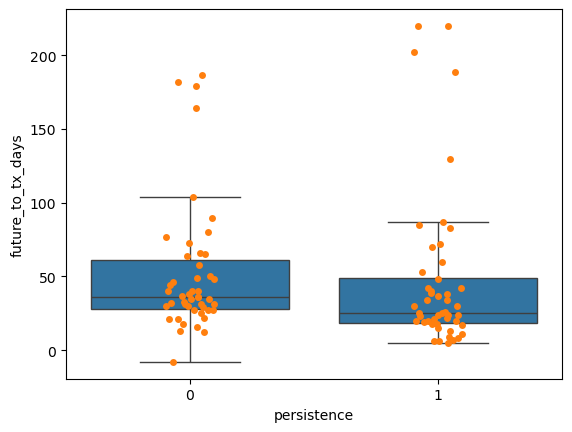

In [14]:
# MDRO POS LARGE DISTRIBUTION ANALYSIS
mdro_pos_large.SampleDate = mdro_pos_large.SampleDate.apply(lambda x: pd.Timestamp(x))
mdro_pos_large.future_sample_date = mdro_pos_large.future_sample_date.apply(lambda x: pd.Timestamp(x))
mdro_pos_large.TxDate = mdro_pos_large.TxDate.apply(lambda x: pd.Timestamp(x))
mdro_pos_large['sample_to_future_days'] = (mdro_pos_large.future_sample_date - mdro_pos_large.SampleDate).apply(lambda x: x.days)
mdro_pos_large['sample_to_tx_days'] = (mdro_pos_large.SampleDate - mdro_pos_large.TxDate).apply(lambda x: x.days)
mdro_pos_large['future_to_tx_days'] = (mdro_pos_large.future_sample_date - mdro_pos_large.TxDate).apply(lambda x: x.days)
sns.boxplot(x=mdro_pos_large.persistence, y=mdro_pos_large.future_to_tx_days, showfliers=False)
sns.stripplot(x=mdro_pos_large.persistence, y=mdro_pos_large.future_to_tx_days, dodge=True)

#MDRO POS LARGE DISTRIBUTION ANALYSIS
mdro_pos_large['future_sequenced'] = mdro_pos_large.apply(lambda r: md_large.loc[md_large['Stool ID'] == r.future_stool, 'sequenced'].iloc[0], axis=1)
mdro_pos_large[['future_sequenced', 'persistence']].value_counts()

#mdro_pos_large.loc[intsct_31,:][['future_sequenced', 'persistence']].value_counts()

In [30]:
islts = pd.read_excel('PLT_all_stool_isolates.xlsx')
islts.rename(columns = {'Stool ID':'StoolID', 'VRE +/-':'VRE', 'old': 'seq2020', 'sequenced': 'seq2023'}, inplace = True)
islts = islts[islts.StudyID.notnull()] #lose 2 samples
islts = islts[~islts.ESBLisolate.apply(lambda v: type(v) is str and "SAME AS" in v)]#remove 4 duplciates


# clean mdro type vars
islts['ESBL'] = islts.ESBLisolate.replace([0, 'N', 'No', '-', 'n', 'N (NO MAC GROWTH)', 'N (ODD)'], 'No').\
    replace(['?', '35379- FALSE + DUE TO BAD PLATES', '35387 (FALSE + DUE TO BAD PLATES)',
            '35393 (FALSE + DUE TO BAD PLATES)'], np.nan).\
     apply(lambda v: np.nan if type(v) is str and 'BOTH FALSE + DUE TO BAD PLATES' in v else v)

islts['KPC'] = islts.KPCisolate.replace(['N', 'n', '-', 0, 'N (AFTER SUB CX)', 'N (NO MAC GROWTH)'], 'No').\
                 replace(['?', 'N (SMALL BLUE?)', '?N '], np.nan)

islts['VRE'] = islts.VRE.replace(['N', '-', 'n', '0'], 'No').replace(['+ (NEG on reculture 3/31)', 'NEG on reculture 4/12'], np.nan).\
    replace(['+', '+ (not pink)', '+ (mauve + blue)', '+ (pink + white)', '+ (mauve)', '+ (white)'], 'Yes')
    
islts = islts.drop(['ESBLisolate', 'KPCisolate'], axis = 1)
#PTNT 186 IS WEIRD W 31331 31332
dupstlid = [31012, 30522, 30100, 30176, 30947, 30327, 30483, 30496, 30919, 31098, 
            31332, 30973, 31277, 31820, 31501, 31899, 31828, 31884, 31808, 32033]
islts = islts[~islts.StoolID.isin(dupstlid)]

# add sequenced status
seq = pd.read_csv('seq2023.csv', header=None)[0]
islts['seq2023'] = islts.StoolID.astype(int).isin(seq)
islts.shape
islts['Clear'] = (islts[['VRE', 'ESBL', 'KPC']] == 'No').all(1)
islts['Positive'] = islts[['VRE', 'ESBL', 'KPC']].applymap(lambda v: v != 'No' and pd.notnull(v)).any(axis=1)


/tmp/ipykernel_1576117/3352746562.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  islts['Positive'] = islts[['VRE', 'ESBL', 'KPC']].applymap(lambda v: v != 'No' and pd.notnull(v)).any(axis=1)


In [39]:
def get_outcome(g):
    g = g.sort_values('SampleDate')
    g = g[(g[['Clear', 'Positive']] == True).any(axis=1)]
    gj = g.join(g.shift(-1), rsuffix='_nxt')
    gj = gj[((gj.SampleDate_nxt - gj.SampleDate) >= min_t) & ((gj.SampleDate_nxt - gj.SampleDate) < max_t)]
    gj['Outcome'] = gj.apply(lambda r: 'Clearance' if r['Clear_nxt'] == True else 'Persistence' if r['Positive_nxt'] == True else np.nan, axis = 1)
    return gj

In [40]:
outcome = islts.groupby('StudyID').apply(get_outcome, include_groups=False).reset_index().drop('level_1', axis = 1)
outcome = outcome[outcome.Positive]
outcome


,StudyID,StoolID,SampleDate,TxDate,VRE,ESBL,KPC,seq2023,Clear,Positive,StoolID_nxt,SampleDate_nxt,TxDate_nxt,VRE_nxt,ESBL_nxt,KPC_nxt,seq2023_nxt,Clear_nxt,Positive_nxt,Outcome
0,5,30004,2014-04-07,NaT,35888,NaN,35022,True,False,True,30011.0,2014-04-17,NaT,35892,NaN,No,False,False,True,Persistence
1,6,30017,2014-04-28,2014-03-26,35893,NaN,"35024, 35025",False,False,True,30019.0,2014-05-05,2014-03-26,35894,35027,35026,False,False,True,Persistence
2,6,30019,2014-05-05,2014-03-26,35894,35027,35026,False,False,True,30029.0,2014-05-20,2014-03-26,35834,No,No,True,False,True,Persistence
3,6,30029,2014-05-20,2014-03-26,35834,No,No,True,False,True,30036.0,2014-06-04,2014-03-26,35835,No,No,False,False,True,Persistence
6,9,30006,2014-04-11,2014-04-07,35889,NaN,No,True,False,True,30010.0,2014-04-16,2014-04-07,35805,NaN,No,False,False,True,Persistence
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,423,31920,2018-12-20,NaT,35954,No,No,False,False,True,31927.0,2019-01-03,NaT,No,P:35958 B:35959,35957,False,False,True,Persistence
749,423,31927,2019-01-03,NaT,No,P:35958 B:35959,35957,False,False,True,31937.0,2019-01-17,NaT,No,No,No,False,True,False,Clearance
750,424,31982,2019-03-29,NaT,35965,No,No,False,False,True,31986.0,2019-04-10,NaT,35966,No,No,False,False,True,Persistence
762,439,32019,2019-06-24,NaT,35974,35971,No,False,False,True,32024.0,2019-07-03,NaT,35976,35978,No,False,False,True,Persistence


In [46]:
cor_small = outcome[outcome.StoolID.isin(mdro_pos_small['Stool ID'])]
cor_small.shape
cor_large = outcome[outcome.StoolID.isin(mdro_pos_large['Stool ID'])]
cor_large.shape

(88, 20)

/tmp/ipykernel_1576117/2094815496.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cor_small['future_sequenced'] = cor_small.apply(lambda r: md_small.loc[md_small['Stool ID'] == int(r.StoolID_nxt), 'sequenced'].iloc[0], axis=1)
/tmp/ipykernel_1576117/2094815496.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cor_small['sample_to_future_days'] = (cor_small.SampleDate_nxt - cor_small.SampleDate).apply(lambda x: x.days)
/tmp/ipykernel_1576117/2094815496.py:4: SettingWithCopyWarning: 
A value is trying t

<Axes: xlabel='Outcome', ylabel='tx_to_future_days'>

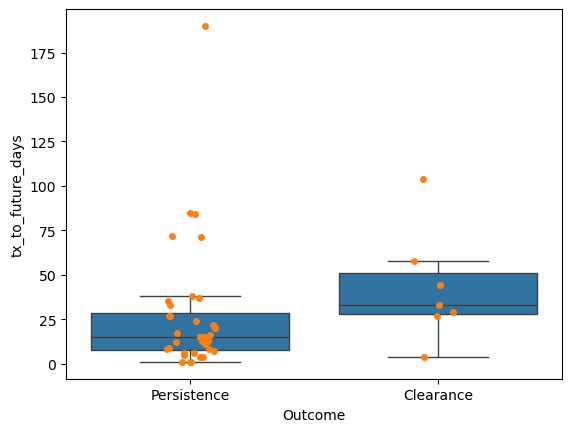

In [52]:
cor_small['future_sequenced'] = cor_small.apply(lambda r: md_small.loc[md_small['Stool ID'] == int(r.StoolID_nxt), 'sequenced'].iloc[0], axis=1)
cor_small[['future_sequenced', 'Outcome']].value_counts()
cor_small['sample_to_future_days'] = (cor_small.SampleDate_nxt - cor_small.SampleDate).apply(lambda x: x.days)
cor_small['tx_to_sample_days']= (cor_small.SampleDate - cor_small.TxDate).apply(lambda x: x.days)
cor_small['tx_to_future_days']= (cor_small.SampleDate_nxt- cor_small.TxDate).apply(lambda x: x.days)
cor_small['course_days_total'] = abx.groupby('StudyID').course_duration.sum().reindex(cor_small.StudyID).values
cor_small['course_days_to_sample'] = cor_small.apply(lambda r: course_days_to_date(abx.loc[abx.StudyID == r.StudyID,:], r.SampleDate), axis=1)
cor_small['course_days_to_future'] = cor_small.apply(lambda r: course_days_to_date(abx.loc[abx.StudyID == r.StudyID, :], r.SampleDate_nxt), axis=1)
cor_small['course_days_since_last_exposure'] = cor_small.apply(lambda r: days_since_last_exposure(abx.loc[abx.StudyID == r.StudyID, :], r.SampleDate), axis=1)
cor_small['course_days_between'] = cor_small.apply(lambda r: days_exposure_btwn(abx.loc[abx.StudyID == r.StudyID, :], r.SampleDate, r.SampleDate_nxt), axis=1)
sns.boxplot(x=cor_small.Outcome, y=cor_small.tx_to_future_days, showfliers=False)
sns.stripplot(x=cor_small.Outcome, y=cor_small.tx_to_future_days, dodge=True)

/tmp/ipykernel_1576117/1243399821.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cor_large['future_sequenced'] = cor_large.apply(lambda r: md_large.loc[md_large['Stool ID'] == int(r.StoolID_nxt), 'sequenced'].iloc[0], axis=1)
/tmp/ipykernel_1576117/1243399821.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cor_large['course_days_total'] = abx.groupby('StudyID').course_duration.sum().reindex(cor_large.StudyID).values
/tmp/ipykernel_1576117/1243399821.py:6: SettingWithCopyWarning: 
A value is trying 

<Axes: xlabel='future_sequenced', ylabel='course_days_between'>

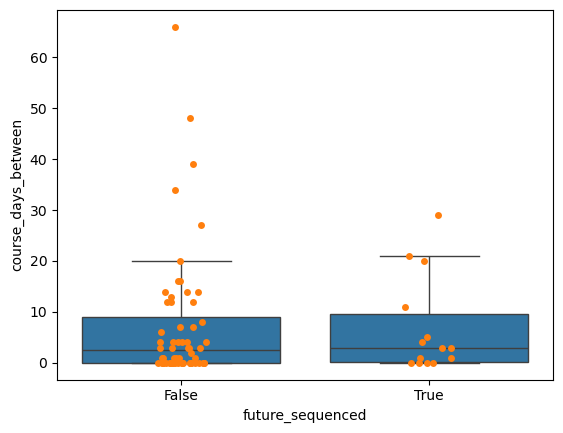

In [50]:
cor_large['future_sequenced'] = cor_large.apply(lambda r: md_large.loc[md_large['Stool ID'] == int(r.StoolID_nxt), 'sequenced'].iloc[0], axis=1)
cor_large[['future_sequenced', 'Outcome']].value_counts()
cor_large['course_days_total'] = abx.groupby('StudyID').course_duration.sum().reindex(cor_large.StudyID).values
cor_large['course_days_to_sample'] = cor_large.apply(lambda r: course_days_to_date(abx.loc[abx.StudyID == r.StudyID,:], r.SampleDate), axis=1)
cor_large['course_days_to_future'] = cor_large.apply(lambda r: course_days_to_date(abx.loc[abx.StudyID == r.StudyID, :], r.SampleDate_nxt), axis=1)
cor_large['course_days_since_last_exposure'] = cor_large.apply(lambda r: days_since_last_exposure(abx.loc[abx.StudyID == r.StudyID, :], r.SampleDate), axis=1)
cor_large['course_days_between'] = cor_large.apply(lambda r: days_exposure_btwn(abx.loc[abx.StudyID == r.StudyID, :], r.SampleDate, r.SampleDate_nxt), axis=1)
cor_large['sample_to_future_days'] = (cor_large.SampleDate_nxt - cor_large.SampleDate).apply(lambda x: x.days)
cor_large['tx_to_sample_days']= (cor_large.SampleDate - cor_large.TxDate).apply(lambda x: x.days)
cor_large['tx_to_future_days']= (cor_large.SampleDate_nxt- cor_large.TxDate).apply(lambda x: x.days)
sns.boxplot(x=cor_large.future_sequenced, y=cor_large.course_days_between, showfliers=False)
sns.stripplot(x=cor_large.future_sequenced, y=cor_large.course_days_between, dodge=True)

In [2]:
# understanding ecol, ncol distributionj
ncol = pd.read_csv("Outcome_allmdro_allclr_txany_abxany_w3-28_seqALL_mr5_02_label_sorted.ncolor.csv", index_col=0)
ecol = pd.read_csv("Outcome_allmdro_allclr_txany_abxany_w3-28_seqALL_mr5_02_label_sorted.ecolor.csv", index_col=0)
ncol

,30779,30239,30784,31581,31252,30548,30142,30766,30705,30493,...,30316,30355,31022,30974,30542,30230,30537,30434,30708,32015
feature,,,,,,,,,,,,,,,,,,,,,
6701324,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6701323,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6701322,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6701321,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6701320,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5967343,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5967344,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5967345,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
p = ncol.iloc[:, 39:].sum(axis=1)/39
q =  ncol.iloc[:, 39:].sum(axis=1)/84
filt = 1 - ((1-p)*(1-q) + q*p)
ncol.loc[filt>0.577225, :]

,30779,30239,30784,31581,31252,30548,30142,30766,30705,30493,...,30316,30355,31022,30974,30542,30230,30537,30434,30708,32015
feature,,,,,,,,,,,,,,,,,,,,,
711060,0,0,0,0,0,0,1,0,0,0,...,0,0,1,1,1,0,0,0,0,0
710876,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
710875,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
710874,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
710853,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803613,0,0,0,1,1,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0
804519,0,0,0,1,1,0,0,0,1,1,...,0,0,1,1,0,0,0,0,0,0
937073,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [31]:
p = ecol.iloc[:, 39:].sum(axis=1)/39
q =  ecol.iloc[:, 39:].sum(axis=1)/84
filt = 1 - ((1-p)*(1-q) + q*p)
ecol.loc[filt>=filt.max(), :]

,30779,30239,30784,31581,31252,30548,30142,30766,30705,30493,...,30316,30355,31022,30974,30542,30230,30537,30434,30708,32015
feature,,,,,,,,,,,,,,,,,,,,,
191424(+) -> 191425(+),0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
260440(+) -> 260441(+),0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,1,0,1,0,0,0
41084(+) -> 41085(+),1,0,1,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,1,0
163345(+) -> 163346(+),1,0,1,0,0,0,1,1,0,0,...,0,0,0,0,1,0,1,0,0,0
46775(-) -> 46775(-),0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123705(+) -> 433666(-),0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
72393(+) -> 72394(+),0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,1,0,1,0,0
181947(-) -> 274687(-),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
